<a href="https://colab.research.google.com/github/RZhang94/H36Choppa/blob/main/hmr2_Video_21_11_27_Validator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a script created by zzx to recreate the results of hmr (a SMPL estimation model) on python 3 and tensorflow 2. Following the instructions from https://github.com/russoale/hmr2.0

Modifications to accept inputs of image arrays and print our the resultant pose/shape parameters. -RZ

In [1]:
# tensorflow 2.6 conflicts with scripts, 2.6+ seems to not add padding
# uninstall tensorflow 2.6
!pip uninstall tensorflow -y
# install tensorflow 2.4
! pip install tensorflow-gpu==2.4.0

Found existing installation: tensorflow 2.7.0
Uninstalling tensorflow-2.7.0:
  Successfully uninstalled tensorflow-2.7.0
     |████████████████████████████████| 394.7 MB 17 kB/s 
     |████████████████████████████████| 3.8 MB 52.5 MB/s 
     |████████████████████████████████| 2.9 MB 63.3 MB/s 
     |████████████████████████████████| 462 kB 67.4 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68715 sha256=50d0e910b8c9422def47138fb874e17b7a25ce7be93fa221cbc5edf5dd6e8c94
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.42.0
    Uninstalling grpcio-1.42.0:
      Successfully uninstalled grpcio-1.

In [2]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
nb_path = '/content/notebooks'
os.symlink('/content/drive/My Drive/Colab Notebooks', nb_path)
sys.path.insert(0,nb_path)

Mounted at /content/drive


# New Section

In [3]:
%cd /content/drive/MyDrive/ECE 740 Data

install = True

if install:

  !pip install --target=$nb_path jdc
  !git clone https://github.com/russoale/hmr2.0.git
  %cd /content/drive/MyDrive/ECE740Data/HMR2/hmr2.0
  !pip install -r requirements.txt
  !mkdir -p logs/paired
  !mkdir -p logs/unpaired
  !pip install trimesh



/content/drive/.shortcut-targets-by-id/10pktlb3WSrMF4VYWKLD8klVdMz-xtIUW/ECE740Data
fatal: destination path 'hmr2.0' already exists and is not an empty directory.
[Errno 2] No such file or directory: '/content/drive/MyDrive/ECE740Data/HMR2/hmr2.0'
/content/drive/.shortcut-targets-by-id/10pktlb3WSrMF4VYWKLD8klVdMz-xtIUW/ECE740Data
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
     |████████████████████████████████| 639 kB 7.5 MB/s 


In [4]:
%cd /content/drive/MyDrive/ECE 740 Data/HMR2/hmr2.0/src

/content/drive/.shortcut-targets-by-id/10pktlb3WSrMF4VYWKLD8klVdMz-xtIUW/ECE740Data/HMR2/hmr2.0/src


In [5]:
# import dependencies

import sys
print(sys.executable, sys.version)

import pdb
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import trimesh

from os.path import join, abspath
from os import mkdir
from IPython.display import display, HTML
from glob import glob
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

%matplotlib inline

# for local import 
sys.path.append(abspath('..'))

from main.config import Config
from main.model import Model
from main.dataset import Dataset
from main.smpl import Smpl
from main.local import LocalConfig

from visualise.vis_util import draw_2d_on_image, show_2d_pose, show_3d_pose, preprocess_image, resize_img

/usr/bin/python3 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]


In [6]:
class DemoConfig(Config):
  BATCH_SIZE = 1
  ENCODER_ONLY = True
  LOG_DIR = abspath('/content/drive/MyDrive/ECE 740 Data/HMR2/hmr2.0/logs/paired/toes_model')
  INITIALIZE_CUSTOM_REGRESSOR = True
  JOINT_TYPE = 'cocoplus'
        
config = DemoConfig()
from main.model import Model

In [7]:
config.LOG_DIR = abspath('/content/drive/MyDrive/ECE 740 Data/HMR2/hmr2.0/logs/paired/toes_model') 
config.INITIALIZE_CUSTOM_REGRESSOR = True
config.JOINT_TYPE= 'custom'
print(config.LOG_DIR)

/content/drive/MyDrive/ECE 740 Data/HMR2/hmr2.0/logs/paired/toes_model


In [8]:
# inizialize model 
import pdb
model = Model()

# here the result is Saving logs to /content/logs/paired/base_model which is not righ

Saving logs to /content/drive/MyDrive/ECE 740 Data/HMR2/hmr2.0/logs/paired/toes_model

Configurations:
BATCH_SIZE                     1
CUSTOM_REGRESSOR_IDX           {0: 'regressor_toes_right.npy', 7: 'regressor_toes_left.npy'}
CUSTOM_REGRESSOR_PATH          /content/drive/.shortcut-targets-by-id/10pktlb3WSrMF4VYWKLD8klVdMz-xtIUW/ECE740Data/HMR2/hmr2.0/models/regressors
DATASETS                       ['lsp', 'lsp_ext', 'mpii', 'coco', 'mpii_3d', 'h36m', 'total_cap']
DATA_DIR                       /data/ssd1/russales/tfrecords
DISCRIMINATOR_LEARNING_RATE    0.0001
DISCRIMINATOR_LOSS_WEIGHT      1
DISCRIMINATOR_WEIGHT_DECAY     0.0001
DS_KP2D                        {'lsp': 14, 'cocoplus': 19, 'custom': 21}
DS_KP3D                        {'lsp': 14, 'cocoplus': 14, 'custom': 16}
ENCODER_INPUT_SHAPE            (224, 224, 3)
ENCODER_ONLY                   True
EPOCHS                         55
GENERATOR_2D_LOSS_WEIGHT       60.0
GENERATOR_3D_LOSS_WEIGHT       60.0
GENERATOR_LEARNING_RATE  

In [ ]:
import os
import cv2 as cv

def subjectparse(subject):
  searchSub = os.path.join('/content/drive/MyDrive/HME/H36M Data/Cropped Images', subject)
  count = -1
  for foldername in os.listdir(searchSub):
    # count += 1
    # if count <79:
    #   continue
    folderparse(subject, os.path.join(searchSub, foldername))
  return
  
def folderparse(subject,folder):
  input_frames = []
  tags = []
  folderdir = os.path.join('/content/drive/MyDrive/HME/H36M Data/Cropped Images', subject, folder)
  for filename in os.listdir(folderdir):
    source = os.path.join(folderdir,filename)
    if cv.imread(source) is not None:
      imageparse(source, tags, input_frames)
  results = createResults(input_frames, tags, folder)
  input_frames.clear
  tags.clear
  saveRes(results, subject, folder)
  return

def saveRes(results, subject, folder):
  print(subject)
  print(folder)
  savedir = os.path.join('/content/drive/MyDrive/HME/H36M Data/Cropped Images',subject, str(folder+ '_results.npy'))
  print(savedir)
  np.save(savedir,results)

def imageparse(image, tags, input_frames):
  loc = image.split('/')
  loc = loc[-3:]
  img, crop, params = preprocess_image(image, 224)
  input_frames.append(crop)
  tags.append(loc)
  return 

def createResults(input_frames, tags, foldername):
  results = []
  joints = []
  joints3d = []
  poses = []
  shapesP = []
  vertices = []
  img_2ds = []
  cams = []

  for image in input_frames:
      result = model.detect(image)
      results.append(result)
      joint = np.squeeze(result['kp2d'].numpy())    # convert the result joints result to numpy array
      joints.append(joint)
      joint3d =  np.squeeze(result['kp3d'].numpy()) 
      joints3d.append(joint3d)
      pose =  np.squeeze(result['pose'].numpy()) 
      poses.append(pose)
      shapeP = np.squeeze(result['shape'].numpy())
      shapesP.append(shapeP)
      

      img_2ds.append(draw_2d_on_image(image, joint))    # draw 2d points on images
      cams.append(np.squeeze(result['cam'].numpy())[:3])  # parameter of the camera
      vertices.append(np.squeeze(result['vertices'].numpy())) # the vertices in SMPL model

  result = np.array([tags, joints, joints3d, poses,shapesP], dtype=object)
  return result





Total Frames Captured: 78
3
(21, 2)
(21, 3)
(82,)
(3,)
Check Random Indexes: [75, 75, 13, 10]
Random Target Frames: [['S11', 'Directions 1.55011271', 'frame_1501.jpg'], ['S11', 'Directions 1.55011271', 'frame_1501.jpg'], ['S11', 'Directions 1.55011271', 'frame_261.jpg'], ['S11', 'Directions 1.55011271', 'frame_201.jpg']]
/content/drive/MyDrive/HME/H36M Data/Cropped Images/S11/Directions 1.55011271/frame_1501.jpg
Resizing image to 224
/content/drive/MyDrive/HME/H36M Data/Cropped Images/S11/Directions 1.55011271/frame_1501.jpg
Resizing image to 224
/content/drive/MyDrive/HME/H36M Data/Cropped Images/S11/Directions 1.55011271/frame_261.jpg
Resizing image to 224
/content/drive/MyDrive/HME/H36M Data/Cropped Images/S11/Directions 1.55011271/frame_201.jpg
Resizing image to 224


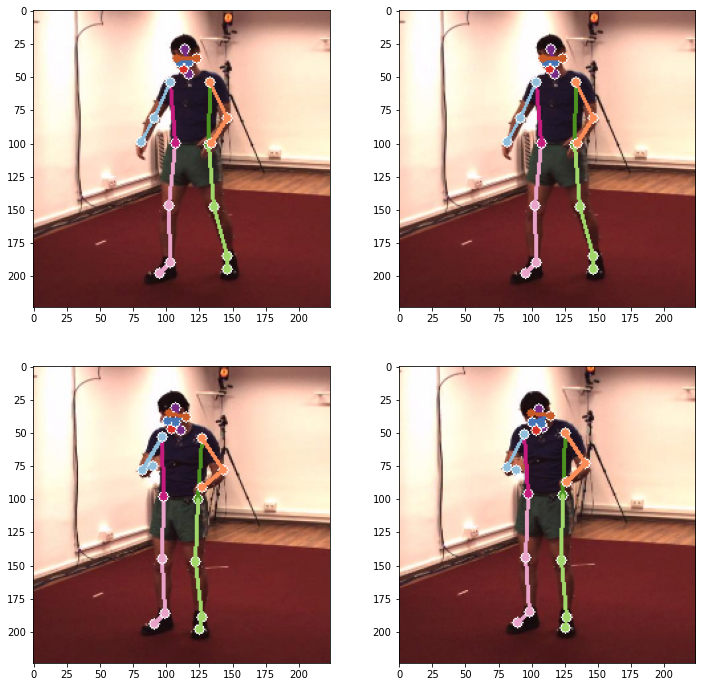

In [46]:
import random
#RZ - Input me a hmr result array to check
#Outputs 4 files to view if the 2d matches the photo.
def summary(test): #Summarize Dimensions to check
    if isinstance(test, list):
        indSize = len(test)
    else:
        indSize = test.shape
    print(indSize)

#Target Directory of the result array to check
def testResult(test):
  test = np.load(testDir, allow_pickle=True)

  points = (len(test[0]))
  print('Total Frames Captured: ' + str(points))
  for a in range(0,5):
    summary(test[a][0])

  #Generate 4 random numbers for photo
  seed = [random.randrange(0,points), random.randrange(0,points), random.randrange(0,points), random.randrange(0,points)]
  seedTar = [test[0][seed[0]],test[0][seed[1]],test[0][seed[2]],test[0][seed[3]]]
  images = []

  print('Check Random Indexes: ' + str(seed))
  print('Random Target Frames: ' + str(seedTar))

  for a in range(0,4):
    dirTags = os.path.join( '/content/drive/MyDrive/HME/H36M Data/Cropped Images', seedTar[a][0],  seedTar[a][1],  seedTar[a][2])
    print(dirTags)
    ori, inp, param = preprocess_image(dirTags,224)
    images.append(draw_2d_on_image(inp, test[1][seed[a]]))    # draw 2d points on images

  f, ax = plt.subplots(2,2)        # f means figure, can do some figure-level attributes change, like figure.size and save figure.
  f.set_size_inches(12,12)
  ax[0,0].imshow(images[0])         # ax is the object that has plotting methods.
  ax[0,1].imshow(images[1])
  ax[1,0].imshow(images[2])         # ax is the object that has plotting methods.
  ax[1,1].imshow(images[3])

  return

testDir = '/content/drive/MyDrive/HME/H36M Data/Cropped Images/Test/Directions 1.55011271_results.npy'
testResult(testDir)


In [ ]:
from visualise.trimesh_renderer import TrimeshRenderer
renderer = TrimeshRenderer()

mesh = renderer.mesh(vertices[0])
mesh.show()

In [ ]:
mesh = renderer.mesh(vertices[1])
mesh.show()

YEAH! Finally we can see the result.